/Users/sumitchand/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.4-CAPI-1.17.4) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/yt/w26mrk4n2njgbd9ykmtx20cr0000gn/T/ipykernel_3004/4126875830.py:3: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch shou

+----+-------------+------------+-------------+----------------+------------------------------------------------------------------------+
|    | device_name | lat_median | long_median | count_sch_hosp |                         school_hospital_names                          |
+----+-------------+------------+-------------+----------------+------------------------------------------------------------------------+
| 0  |   TARA004   |   28.47    |    77.0     |       3        | Shree Krishna Hospital, Gurgaon, Esic Hospital, Gurugram, ESI hospital |
| 4  |   TARA014   |   28.43    |    77.05    |       2        |    Delhi Public School, Primary Section, Sukhmani Hospital Pvt. Ltd    |
| 11 |   TARA036   |   28.45    |    77.03    |       2        |          Pushpanjali Hospital, Pushpanjali Hospital, Gurgaon           |
| 1  |   TARA007   |   28.48    |    77.01    |       1        |                         Sneh Hospital, Gurgaon                         |
| 9  |   TARA029   |   28.44    | 

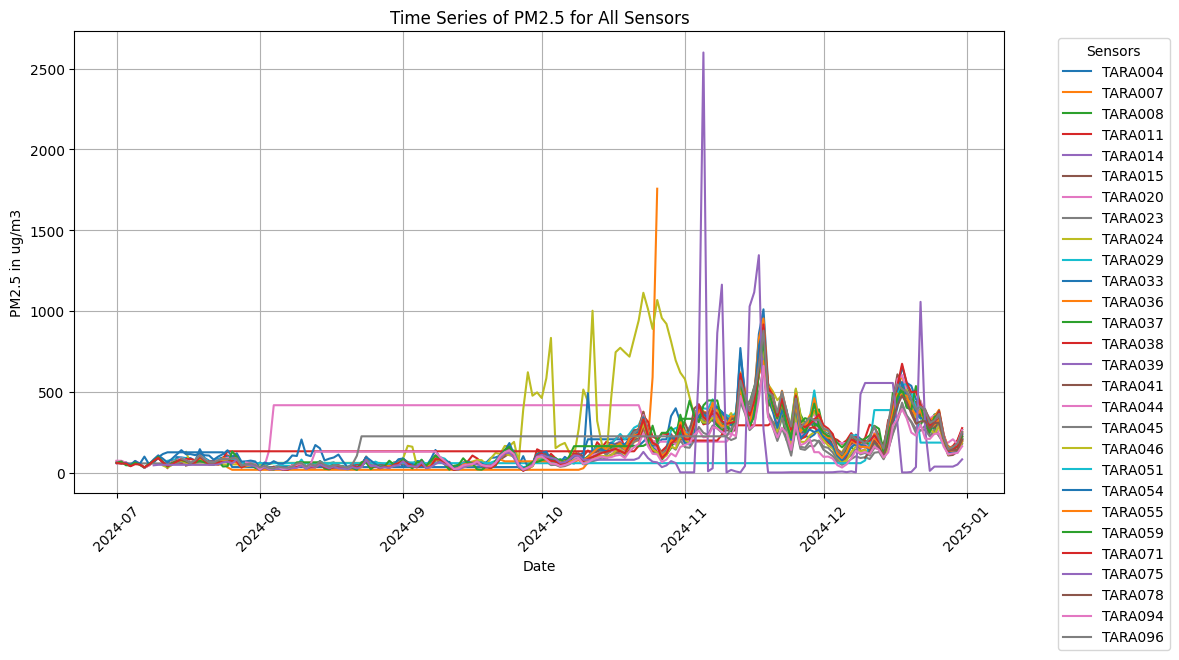

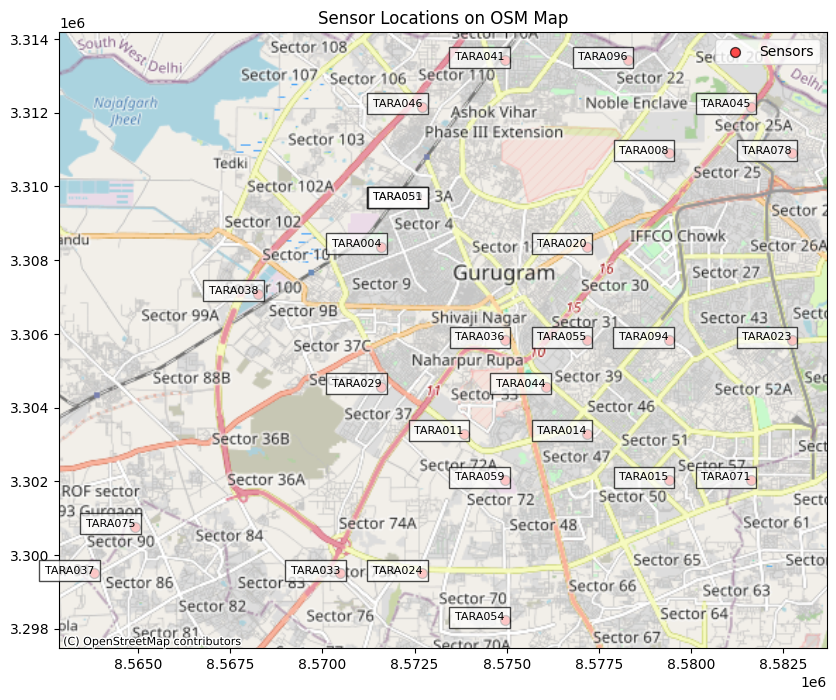

In [1]:
import os
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import contextily as ctx  # For OSM basemap
from shapely.geometry import Point
from tabulate import tabulate
from datetime import datetime

# Load Data
lcs_file = '/Users/sumitchand/Downloads/Static_Ggn_input_bfill.csv'
schools_hospitals_file = '/Users/sumitchand/Downloads/schools_and_hospitals_gurugram.csv'

df = pd.read_csv(lcs_file, usecols=['device_name', 'lat_median', 'long_median', 'data_created_time', 'id', 'pm_25', 'pm_10', 'no2', 'co', 'temp', 'rh'])
df_sch_hosp = pd.read_csv(schools_hospitals_file)

df['data_created_time'] = pd.to_datetime(df['data_created_time'])
df_sch_hosp[['Latitude', 'Longitude']] = df_sch_hosp[['Latitude', 'Longitude']].round(2)

# Extract unique device locations
unique_devices = df[['device_name', 'lat_median', 'long_median']].drop_duplicates()

# Create GeoDataFrames
gdf_devices = gpd.GeoDataFrame(unique_devices, 
                              geometry=gpd.points_from_xy(unique_devices['long_median'], unique_devices['lat_median']), 
                              crs="EPSG:4326")
gdf_sch_hosp = gpd.GeoDataFrame(df_sch_hosp, geometry=gpd.points_from_xy(df_sch_hosp['Longitude'], df_sch_hosp['Latitude']), crs="EPSG:4326")

# Convert to UTM projection for distance calculations
gdf_devices = gdf_devices.to_crs(epsg=32643)
gdf_sch_hosp = gdf_sch_hosp.to_crs(epsg=32643)

# Create 1km buffer around devices
gdf_devices['buffer'] = gdf_devices.geometry.buffer(1000)

# Spatial Join to count nearby schools/hospitals
joined = gpd.sjoin(gdf_sch_hosp, gdf_devices, predicate="within")
result = joined.groupby('device_name').agg(count_sch_hosp=('Name', 'count'), school_hospital_names=('Name', lambda x: ', '.join(x))).reset_index()

# Merge results with device locations
final_table = gdf_devices[['device_name', 'lat_median', 'long_median']].merge(result, on='device_name', how='left').fillna({'count_sch_hosp': 0, 'school_hospital_names': 'None'})
final_table['count_sch_hosp'] = final_table['count_sch_hosp'].astype(int)

# Display filtered locations with nearby schools/hospitals
filtered_table = final_table[final_table['count_sch_hosp'] > 0].sort_values(by='count_sch_hosp', ascending=False)
print(tabulate(filtered_table, headers='keys', tablefmt='pretty'))

# Time Series Analysis
df['date'] = df['data_created_time'].dt.date
df_daily_avg = df.groupby(['device_name', 'date'])[['pm_25', 'temp', 'rh']].mean().reset_index()

# Visualization
plt.figure(figsize=(12, 6))
for sensor in df['device_name'].unique():
    sensor_data = df_daily_avg[df_daily_avg['device_name'] == sensor]
    plt.plot(sensor_data['date'], sensor_data['pm_25'], label=sensor)
plt.xlabel('Date')
plt.ylabel('PM2.5 in ug/m3')
plt.title('Time Series of PM2.5 for All Sensors')
plt.xticks(rotation=45)
plt.legend(title="Sensors", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

# Mapping Sensors on OSM
gdf_sensors = gpd.GeoDataFrame(final_table[['device_name', 'lat_median', 'long_median']],
                               geometry=gpd.points_from_xy(final_table['long_median'], final_table['lat_median']), crs="EPSG:4326").to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(10, 8))
gdf_sensors.plot(ax=ax, color='red', markersize=50, alpha=0.7, edgecolor='black', label="Sensors")
for x, y, label in zip(gdf_sensors.geometry.x, gdf_sensors.geometry.y, gdf_sensors['device_name']):
    ax.text(x, y, label, fontsize=8, ha='right', color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title('Sensor Locations on OSM Map')
ax.legend()
plt.savefig("/Users/sumitchand/Downloads/sensor_map.png", dpi=300, bbox_inches='tight')
plt.savefig("/Users/sumitchand/Downloads/sensor_map.pdf", dpi=300, bbox_inches='tight')
plt.show()